In [9]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, adjusted_rand_score, homogeneity_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.svm import SVC
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.manifold import TSNE

from scipy.stats import kurtosis

In [3]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

scaler_cred_full = StandardScaler()
scaler_cred_full.fit(X_cred)
X_cred = pd.DataFrame(scaler_cred_full.transform(X_cred), index=y_cred.index)


X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)
X_mnist = pd.DataFrame(X_mnist / 255.0, index=y_mnist.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}
cred_full = {"X": X_cred, "y": y_cred, "name": "Credit Full"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}
mnist_full = {"X": X_mnist, "y": y_mnist, "name": "MNIST Full"}

In [4]:
def build_kmeans_elbow_data(data_set, max_k=15):
    X, y, name = get_data(data_set)
    
    km_scores= []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
        
    print("="*100)
    for i in range(2,max_k):
        print("Clusters: ", i)

        km = KMeans(n_clusters=i,
                    init="k-means++",
                    n_jobs=-1,
                    verbose=2,
                    precompute_distances=True,
                    random_state=random_state).fit(X)
        preds = km.predict(X)
    
        # Kmeans score
        print("K-means score:        {}".format(km.score(X)))
        km_scores.append(-km.score(X))

        # Silhouette score
        silhouette = silhouette_score(X,preds)
        km_silhouette.append(silhouette)
        print("Silhouette score:     {}".format(silhouette))
    
        # Davies Boulding score
        db = davies_bouldin_score(X,preds)
        db_score.append(db)
        print("Davies Bouldin score: {}".format(db))
    
        # V-measure score   
        v_measure = v_measure_score(y.values.ravel(), preds)
        vmeasure_score.append(v_measure)
        print("V-measure score:      {}".format(v_measure))
        print("-"*100)
    
    return (km_scores, km_silhouette, vmeasure_score, db_score)

In [5]:
def build_kmeans_plots(title, k, s, v, d, clusters=None):
    if clusters is None:
        clusters = range(2, len(k) + 2)
        
    _, axes = plt.subplots(1, 4, figsize=(28, 7))
    
    axes[0].set_title(title + " - K-means Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("K-means Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, k, '-o')
    
    axes[1].set_title(title + " - Silhouette Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Silhouette Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, s, '-o')
   
    axes[2].set_title(title + " - Davies Boulding Score")
    axes[2].set_xlabel("Clusters")
    axes[2].set_ylabel("Davies Boulding Score")
    axes[2].set_xticks(clusters)
    axes[2].grid()
    axes[2].plot(clusters, d, '-o')

    axes[3].set_xlabel("Clusters")
    axes[3].set_ylabel("V-measure score")
    axes[3].set_xticks(clusters)
    axes[3].grid()
    axes[3].plot(clusters, v, '-o')
    
    plt.show()

In [104]:
def show_digits(data_set, digit_ids, title):
    X, y, name = get_data(data_set)
    
    fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True)
    fig.set_figheight(7)
    fig.set_figwidth(7)
    fig.suptitle(title, fontsize=12)

    image_id = 0
    for i in range(10):
        for j in range(10):
            axes[i][j].imshow(X.loc[digit_ids[image_id], :].values.reshape([28,28]), cmap=plt.get_cmap('gray'))
            axes[i][j].xaxis.set_major_locator(plt.NullLocator())
            axes[i][j].yaxis.set_major_locator(plt.NullLocator())

            image_id += 1

In [29]:
def cumulative_variance_pca(pca, title, percentile=0.9):
    cum_var = []
    sum = 0
    count = 0
    x_marker = 0
    for ratio in pca.explained_variance_ratio_:
        sum += ratio
        if sum >= percentile:
            x_marker = count
        else:
            count += 1
            
        cum_var.append(sum)

    y_marker = cum_var[x_marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")

    plt.title(title + " - {}% Variance Explained by Top {} Components".format(int(percentile * 100), x_marker))
    plt.plot(range(len(pca.explained_variance_ratio_)), cum_var, label="Cumulative Variance")
    plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Variance")
    plt.ylabel("% Variance Explained")
    plt.xlabel("Top n components used")
    plt.legend(loc="best")
    plt.show()

In [20]:
def two_comp_scatter(X, yDF, title):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title(title)

In [28]:
def select_comp_scatter(X, yDF, c1, c2, algo):
    xDF = pd.DataFrame(data=X, index=range(len(X)))
    tempDF = pd.DataFrame(data=xDF.loc[:,[c1, c2]], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations - {}".format(algo))

In [108]:
def dominant_component(comps):
    return {
        "comp, feat": list(zip(range(len(comps)),list(np.argmax(comps, axis=1)))),
        "feat, comp": list(zip(range(len(comps[0])),list(np.argmax(comps, axis=0))))
    }

In [109]:
def mse(data, reconstruction):
    return np.mean(((data - reconstruction) ** 2).values)

In [110]:
def rp_reconstruction(transformed, components):
    return np.dot(transformed, np.linalg.pinv(components.T))

In [111]:
def rp_svm_cross_val(data, n_comp, random_state, scoring):
    X, y, _ = get_data(data)
    
    rp = GaussianRandomProjection(n_components=n_comp, random_state=random_state)
    transformed = rp.fit_transform(X)
    csvm = SVC(C=5,gamma=0.01,kernel='rbf',cache_size=60000,random_state=random_state)
    scores = cross_val_score(csvm, transformed, y, cv=5, scoring=scoring, n_jobs=-1, pre_dispatch="2*n_jobs")
    
    return np.mean(scores)

In [112]:
def rp_comp_error(data, n_comp, runs=10):
    X, y, _ = get_data(data)

    def run(i, error):
        rp = GaussianRandomProjection(n_components=n_comp, random_state=i)
        transformed = rp.fit_transform(X)
        reconstructed = rp_reconstruction(transformed, rp.components_)
        error.append(mse(X, reconstructed))
    
    error = []
    for i in range(runs):
        run(i, error)

    error_mean = np.mean(error)
    error_std = np.std(error)
        
    return (n_comp, error_mean, error_std)

In [113]:
def recon_error_plot(recon_error, title, error=0.1):
    x = [tup[0] for tup in recon_error]
    e_mean = np.array([tup[1] for tup in recon_error])
    e_std = np.array([tup[2] for tup in recon_error])
    
    marker = 0
    for i in range(len(e_mean)):
        if e_mean[i] >= error:
            marker = i
    y_marker = e_mean[marker]
    x_marker = x[marker]
    plt.axhline(y=y_marker, linestyle="--", color="red")
    plt.axvline(x=x_marker, linestyle="--", color="red")
    title += "\n{} Mean Square Error with {} Components".format(round(y_marker, 3), x_marker)
    
    plt.title(title)
    plt.plot(x, e_mean, label="Reconstruction Error", lw=2)
    plt.fill_between(x, e_mean - e_std, e_mean + e_std, alpha=0.1)
    plt.ylabel("MSE")
    plt.xlabel("Components")
    plt.legend(loc="best")
    plt.show()

In [19]:
def tSNE_transform(data, perplexity=50, n_iter=1000, scale_down=0.9):
    X = data['X']
    y = data['y']
    
    X, _, y, _ = train_test_split(X, y, test_size=scale_down,random_state=random_state,stratify=y)
    
    return TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, n_jobs=-1).fit_transform(X)

# K-means Credit

## PCA

In [54]:
Xc, yc, _ = get_data(cred_full)
pca_cred = PCA(n_components=12, random_state=random_state)
X_cred_pca = pca_cred.fit_transform(Xc)

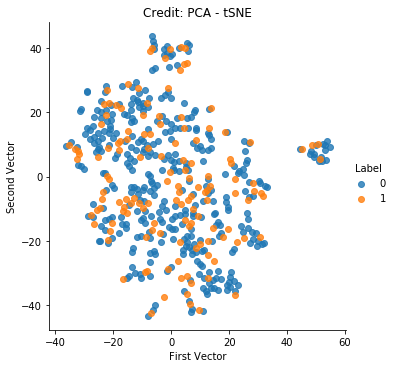

In [82]:
data = {'X': X_cred_pca, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: PCA - tSNE')

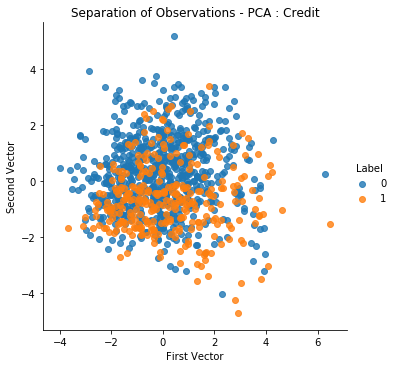

In [115]:
two_comp_scatter(X_cred_pca, yc, "PCA : Credit")

In [116]:
cred_pca = {"X": X_cred_pca, "y": y_cred, "name": "Credit PCA"}
ck, cs, cv, cd = build_kmeans_elbow_data(cred_pca)

Clusters:  2
K-means score:        -13716.250024830082
Silhouette score:     0.10726479848564259
Davies Bouldin score: 2.760135099577699
V-measure score:      9.510894618879757e-06
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -12706.747197268583
Silhouette score:     0.10047456471726278
Davies Bouldin score: 2.502114521640228
V-measure score:      0.04668263510043122
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -11737.567230259123
Silhouette score:     0.11386248840235788
Davies Bouldin score: 2.1346765244378365
V-measure score:      0.05798817755203401
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -11061.432766510945
Silhouette score:     0.12127866798041134
Davies Bouldin score: 1.9730646352823746
V-measure score:   

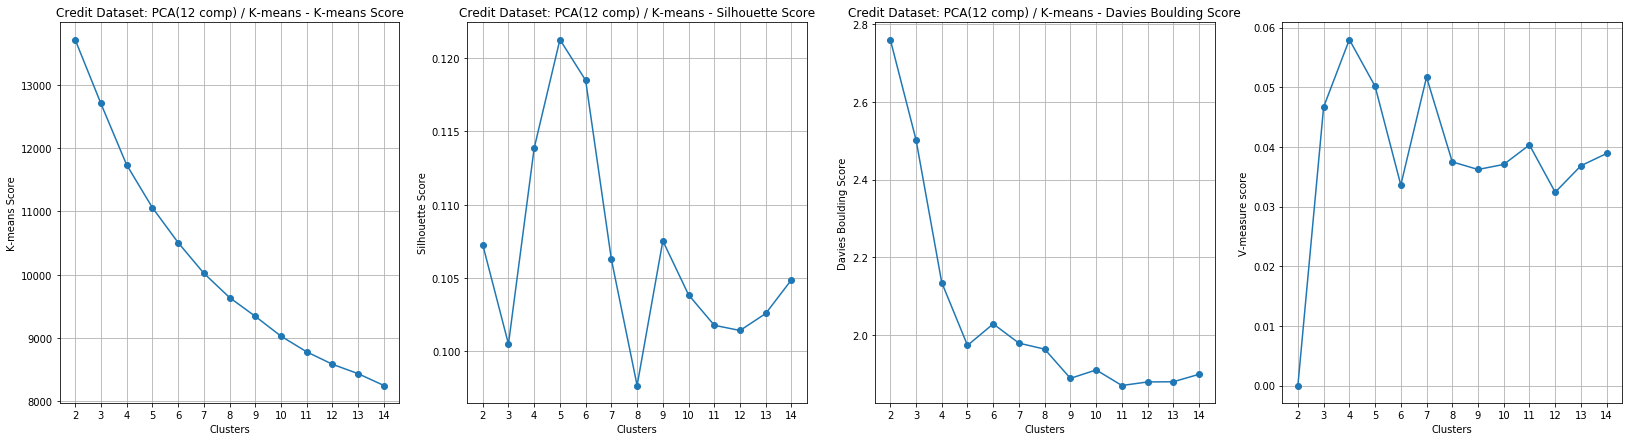

In [117]:
ctitle = "Credit Dataset: PCA(12 comp) / K-means"
build_kmeans_plots(ctitle, ck,cs,cv,cd)

In [200]:
# 5 clusters Credit
Xc, yc, name = get_data(cred_pca)
km_5 = KMeans(n_clusters=5,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_5_pred = km_5.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_5_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_5_pred, yc.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xc, km_5.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_5.labels_))

Adjusted Rand Score:      0.021185937032165456
Homogeneity Score:        0.030396220565584473
Silhouette Score:         0.14019019678157804
Calinski Harabasz Score:  133.81236627051507


## ICA

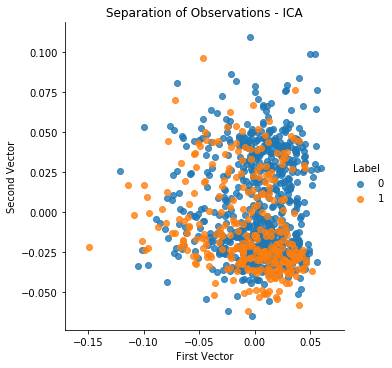

In [80]:
Xc, yc, _ = get_data(cred_full)
ica_cred = FastICA(n_components=7, whiten=True, random_state=random_state, tol=0.005)
X_cred_ica = ica_cred.fit_transform(Xc)
select_comp_scatter(X_cred_ica, yc, 1 ,6, "ICA")

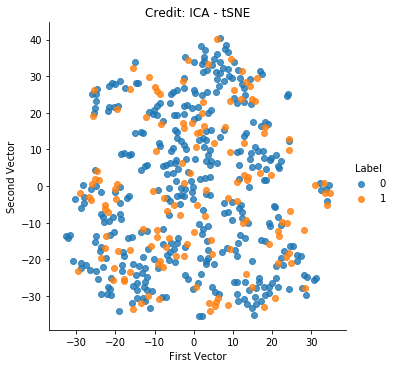

In [81]:
data = {'X': X_cred_ica, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: ICA - tSNE')

In [120]:
cred_ica = {"X": X_cred_ica, "y": y_cred, "name": "Credit PCA"}
ck, cs, cv, cd = build_kmeans_elbow_data(cred_ica)

Clusters:  2
K-means score:        -6.213761187292313
Silhouette score:     0.1250218640050377
Davies Bouldin score: 2.59372294076497
V-measure score:      0.018099397692122383
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -5.687827704580749
Silhouette score:     0.12280957001144815
Davies Bouldin score: 2.3478159298270516
V-measure score:      0.027330404819572728
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -5.253902485190793
Silhouette score:     0.11869066798906147
Davies Bouldin score: 2.10460744468479
V-measure score:      0.00999996727752034
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -4.829434587341818
Silhouette score:     0.12354252726722506
Davies Bouldin score: 1.9057189526311298
V-measure score:      0.01

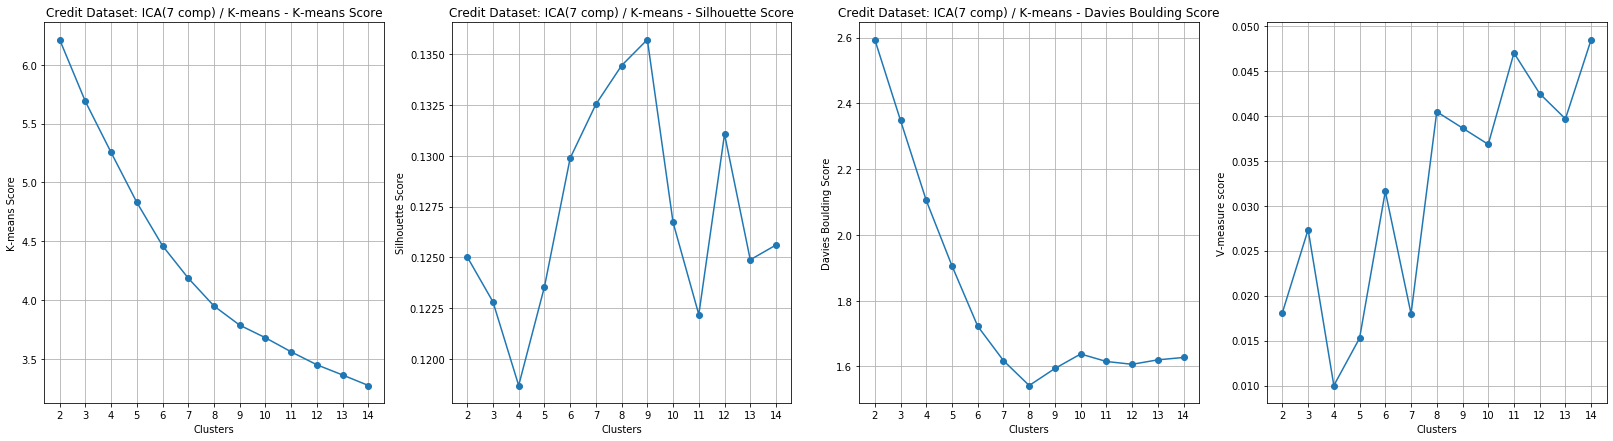

In [121]:
ctitle = "Credit Dataset: ICA(7 comp) / K-means"
build_kmeans_plots(ctitle, ck,cs,cv,cd)

In [201]:
# 8 clusters Credit
Xc, yc, name = get_data(cred_ica)
km_8 = KMeans(n_clusters=8,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_8_pred = km_8.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_8_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_8_pred, yc.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xc, km_8.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_8.labels_))

Adjusted Rand Score:      0.015828799124434453
Homogeneity Score:        0.026314450398611442
Silhouette Score:         0.13444149404412684
Calinski Harabasz Score:  109.54524882024285


In [199]:
# 9 clusters Credit
Xc, yc, name = get_data(cred_ica)
km_9 = KMeans(n_clusters=9,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_9_pred = km_9.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_9_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_9_pred, yc.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xc, km_9.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_9.labels_))

Adjusted Rand Score:      0.013444371349920665
Homogeneity Score:        0.024798438135422707
Silhouette Score:         0.13571900594691147
Calinski Harabasz Score:  105.20388094577491


# Random Projection

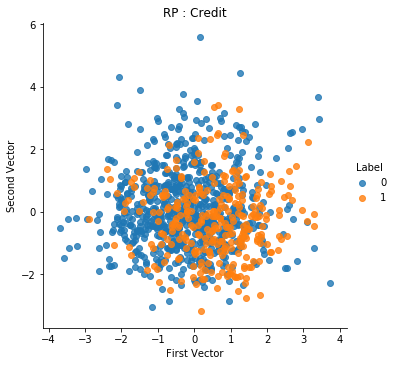

In [78]:
Xc, yc, _ = get_data(cred_full)
cred_rp = GaussianRandomProjection(n_components=12, random_state=random_state)
X_cred_rp = cred_rp.fit_transform(Xc)
two_comp_scatter(X_cred_rp, yc, "RP : Credit")

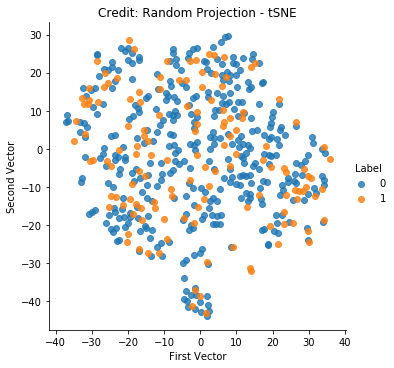

In [79]:
data = {'X': X_cred_rp, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=20, n_iter=5000, scale_down=0.5)
two_comp_scatter(x_tsne, yc, 'Credit: Random Projection - tSNE')

In [125]:
cred_rp = {"X": X_cred_rp, "y": y_cred, "name": "Credit Random Projection"}
ck, cs, cv, cd = build_kmeans_elbow_data(cred_rp)

Clusters:  2
K-means score:        -16866.408127052186
Silhouette score:     0.15259341744650062
Davies Bouldin score: 2.299104511535886
V-measure score:      0.010631332399834624
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -14868.617454682633
Silhouette score:     0.1505805359984912
Davies Bouldin score: 1.9486367244228722
V-measure score:      0.02919557618085913
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -13768.351479452675
Silhouette score:     0.1316853946602292
Davies Bouldin score: 1.9275750794102902
V-measure score:      0.0437134968215615
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -12861.340252593161
Silhouette score:     0.14019019678157804
Davies Bouldin score: 1.7908733387369171
V-measure score:      

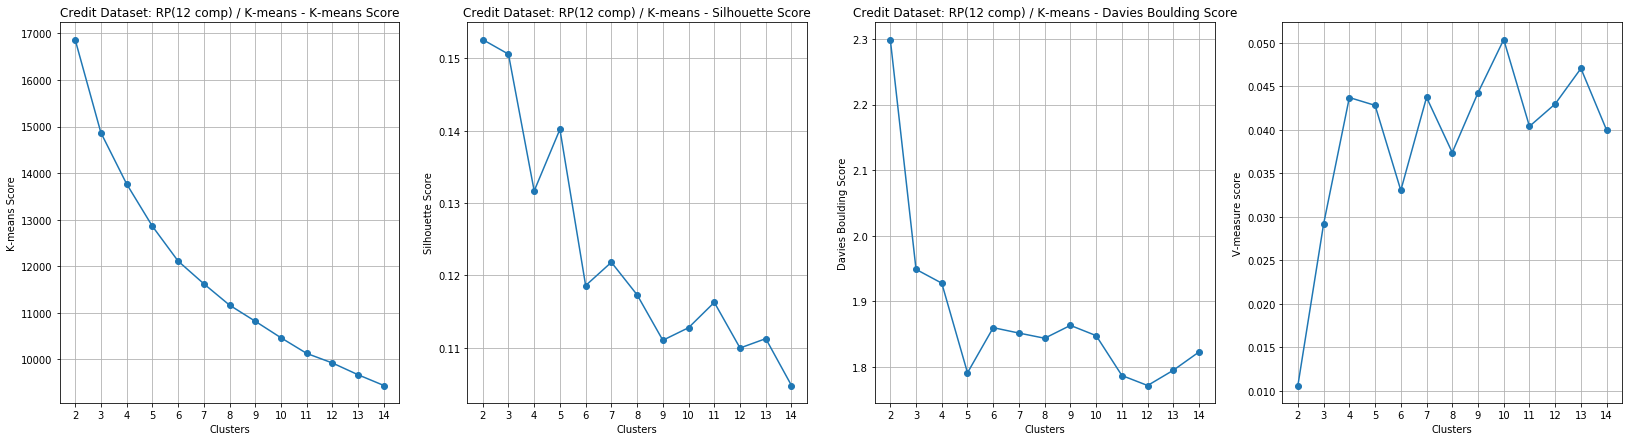

In [126]:
ctitle = "Credit Dataset: RP(12 comp) / K-means"
build_kmeans_plots(ctitle, ck,cs,cv,cd)

In [198]:
# 5 clusters Credit
Xc, yc, name = get_data(cred_rp)
km_5 = KMeans(n_clusters=5,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_5_pred = km_5.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_5_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_5_pred, yc.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xc, km_5.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_5.labels_))

Adjusted Rand Score:      0.021185937032165456
Homogeneity Score:        0.030396220565584473
Silhouette Score:         0.14019019678157804
Calinski Harabasz Score:  133.8123662705151


# Dictionary Learning

In [40]:
Xc, yc, _ = get_data(cred_full)

dl = MiniBatchDictionaryLearning(n_components=11,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
X_cred_dl = dl.fit_transform(Xc)

In [43]:
data = {'X': X_cred_dl, 'y': yc}
x_tsne = tSNE_transform(data, perplexity=30, n_iter=5000, scale_down=0.5)

In [ ]:
two_comp_scatter(x_tsne, yc, 'Credit: Dictionary Learning - tSNE')

In [46]:
cred_dl = {"X": X_cred_dl, "y": y_cred, "name": "Credit Dictionary Learning"}
ck, cs, cv, cd = build_kmeans_elbow_data(cred_dl)

Clusters:  2
K-means score:        -9290.144411008521
Silhouette score:     0.08875767864337007
Davies Bouldin score: 3.2428713057123812
V-measure score:      0.027157674231529434
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -8493.70837862726
Silhouette score:     0.12652807436918423
Davies Bouldin score: 2.386455425945128
V-measure score:      0.04405392777437187
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -7820.28163466218
Silhouette score:     0.10936182678730427
Davies Bouldin score: 2.0146827730894454
V-measure score:      0.010586436617464745
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -7156.145139863469
Silhouette score:     0.13582037290466797
Davies Bouldin score: 2.0056523007912324
V-measure score:      0.

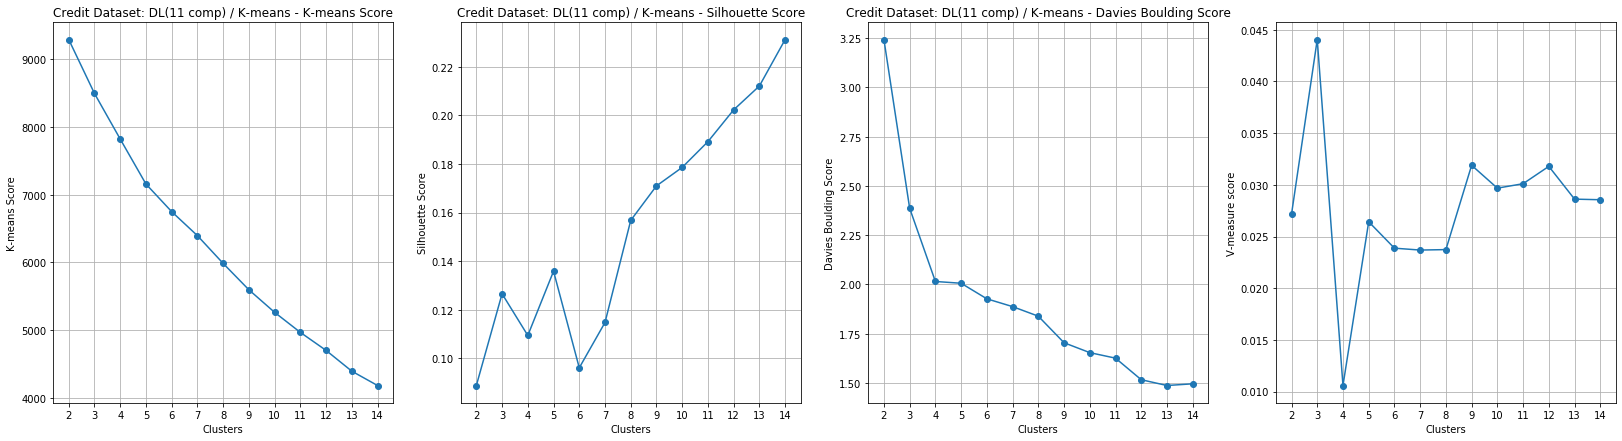

In [47]:
ctitle = "Credit Dataset: DL(11 comp) / K-means"
build_kmeans_plots(ctitle, ck, cs, cv, cd)

In [49]:
# 5 clusters Credit
Xc, yc, name = get_data(cred_dl)
km_5 = KMeans(n_clusters=5,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_5_pred = km_5.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_5_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_5_pred, yc.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xc, km_5.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_5.labels_))

Adjusted Rand Score:      0.02702109024834692
Homogeneity Score:        0.01947630888599714
Silhouette Score:         0.13582037290466797
Calinski Harabasz Score:  101.63199471917186


# K-means MNIST

## PCA

In [76]:
Xm, ym, _ = get_data(mnist)
pca_mnist = PCA(n_components=153, random_state=random_state)
X_mnist_pca = pca_mnist.fit_transform(Xm)

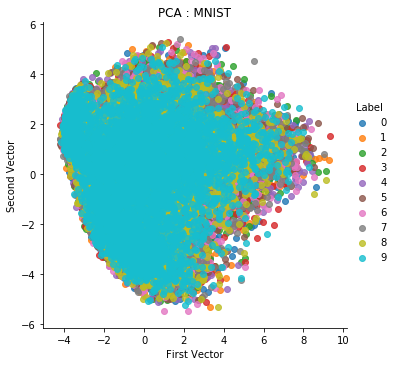

In [33]:
two_comp_scatter(X_mnist_pca, ym, "PCA : MNIST")

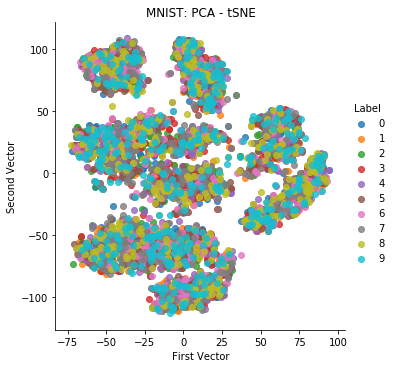

In [77]:
data = {'X': X_mnist_pca, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: PCA - tSNE')

In [147]:
mnist_pca = {"X": X_mnist_pca, "y": y_mnist_train, "name": "MNIST PCA"}
mk, ms, mv, md = build_kmeans_elbow_data(mnist_pca)

Clusters:  2
K-means score:        -2615124.422141653
Silhouette score:     0.0909051822468212
Davies Bouldin score: 3.6337002906473614
V-measure score:      0.16458801469999376
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -2479699.0348265404
Silhouette score:     0.057885303669504146
Davies Bouldin score: 3.1753567864524492
V-measure score:      0.28844945999806826
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -2376793.187007799
Silhouette score:     0.06488152682312719
Davies Bouldin score: 3.0484146010149624
V-measure score:      0.3799516681194663
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -2283316.4098257255
Silhouette score:     0.07259266195668378
Davies Bouldin score: 2.8338481130801485
V-measure score:      

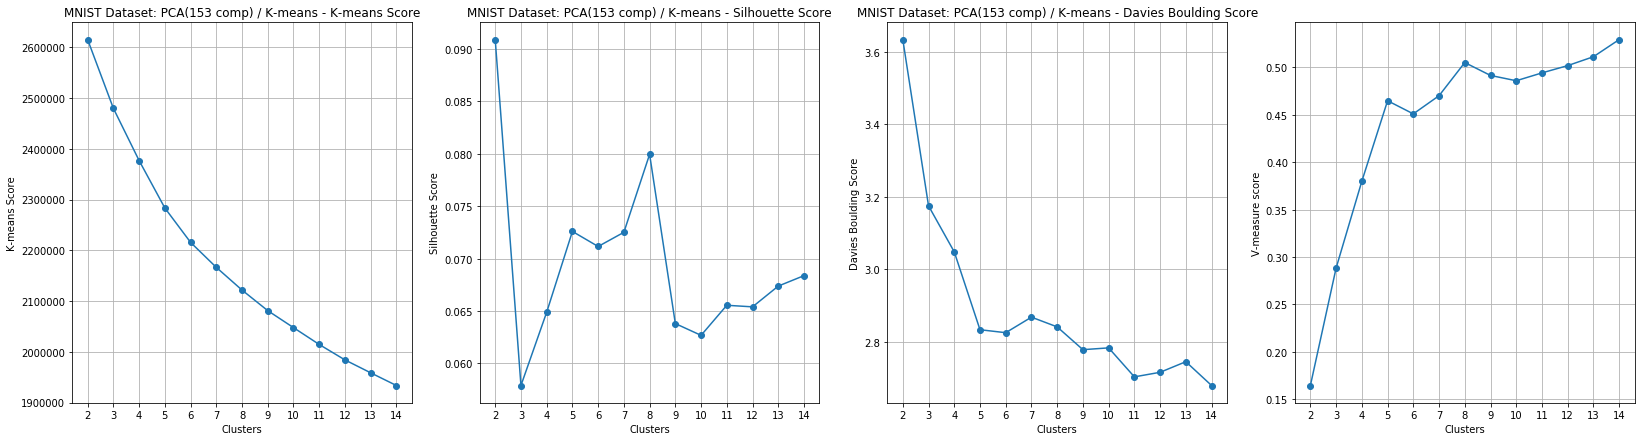

In [148]:
mtitle = "MNIST Dataset: PCA(153 comp) / K-means"
build_kmeans_plots(mtitle, mk,ms,mv,md)

In [197]:
# 8 clusters MNIST
Xm, ym, name = get_data(mnist_pca)
km_8 = KMeans(n_clusters=8,
              init="k-means++",
              n_jobs=-1,
              precompute_distances=True,
              random_state=random_state).fit(Xm)

km_8_pred = km_8.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_8_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_8_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km_8.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km_8.labels_))

Adjusted Rand Score:      0.39530562537357117
Homogeneity Score:        0.536934754001592
Silhouette Score:         0.07995330981477301
Calinski Harabasz Score:  2579.6893460551746


## ICA

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


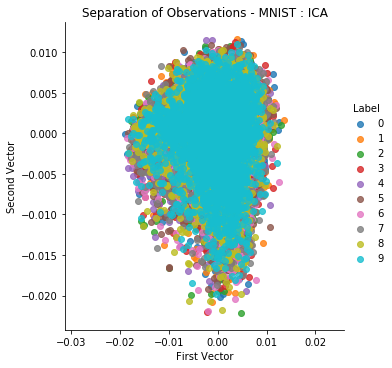

In [74]:
Xm, ym, _ = get_data(mnist)
ica_mnist = FastICA(n_components=11, whiten=True, random_state=random_state, tol=0.005)
X_mnist_ica = ica_mnist.fit_transform(Xm)
select_comp_scatter(X_mnist_ica, ym, 2 ,9, "MNIST : ICA")

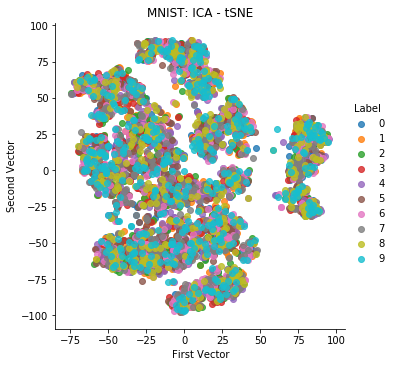

In [75]:
data = {'X': X_mnist_ica, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: ICA - tSNE')

In [161]:
mnist_ica = {"X": X_mnist_ica, "y": y_mnist_train, "name": "MNIST ICA"}
mk, ms, mv, md = build_kmeans_elbow_data(mnist_ica)

Clusters:  2
K-means score:        -10.230203376801471
Silhouette score:     0.09574309660266431
Davies Bouldin score: 3.457873451570639
V-measure score:      0.2152423381608716
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -9.545229506350534
Silhouette score:     0.08865986067000238
Davies Bouldin score: 2.9606709868598036
V-measure score:      0.37830265130296764
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -8.931617605796088
Silhouette score:     0.10194159728654512
Davies Bouldin score: 2.56251007073885
V-measure score:      0.3599684703083678
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -8.396190132380793
Silhouette score:     0.11449138580371716
Davies Bouldin score: 2.366354694943708
V-measure score:      0.3974

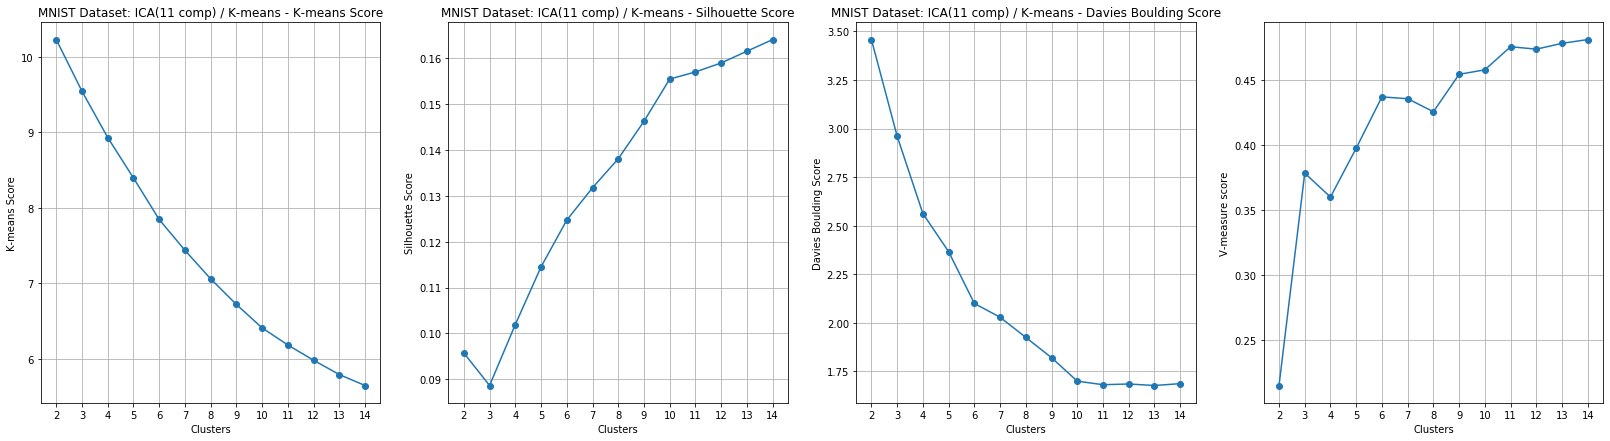

In [162]:
mtitle = "MNIST Dataset: ICA(11 comp) / K-means"
build_kmeans_plots(mtitle, mk,ms,mv,md)

In [202]:
# 10 clusters Credit
Xm, ym, name = get_data(mnist_ica)
km_10 = KMeans(n_clusters=10,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_10_pred = km_10.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_10_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_10_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km_10.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km_10.labels_))

Adjusted Rand Score:      0.3247314355327136
Homogeneity Score:        0.4603114733203921
Silhouette Score:         0.15540135628324753
Calinski Harabasz Score:  4457.102931013949


# Random Projection

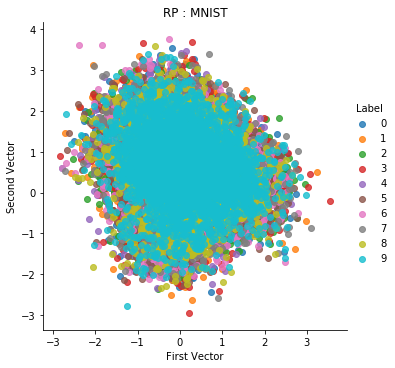

In [72]:
Xm, ym, _ = get_data(mnist)
mnist_rp = GaussianRandomProjection(n_components=84, random_state=random_state)
X_mnist_rp = mnist_rp.fit_transform(Xm)
two_comp_scatter(X_mnist_rp, ym, "RP : MNIST")

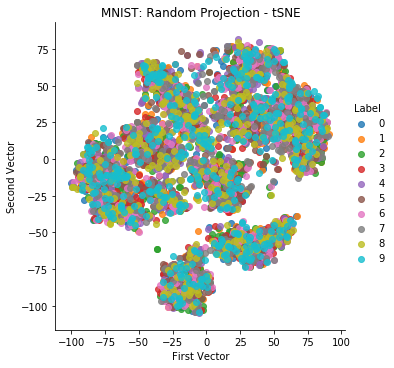

In [73]:
data = {'X': X_mnist_rp, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)
two_comp_scatter(x_tsne, ym, 'MNIST: Random Projection - tSNE')

In [155]:
mnist_rp = {"X": X_mnist_rp, "y": y_mnist_train, "name": "MNIST Random Projection"}
mk, ms, mv, md = build_kmeans_elbow_data(mnist_rp)

Clusters:  2
K-means score:        -2700758.0067479135
Silhouette score:     0.08187163269433315
Davies Bouldin score: 3.7524158467934536
V-measure score:      0.14166555428960112
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -2565010.0488626007
Silhouette score:     0.05970901714364699
Davies Bouldin score: 3.3863056246219507
V-measure score:      0.20797826428048521
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -2456526.3492269553
Silhouette score:     0.06545674076064202
Davies Bouldin score: 3.060122164277911
V-measure score:      0.30823037163105194
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -2368735.50774647
Silhouette score:     0.06263149645234
Davies Bouldin score: 2.9007047481059245
V-measure score:      0.3

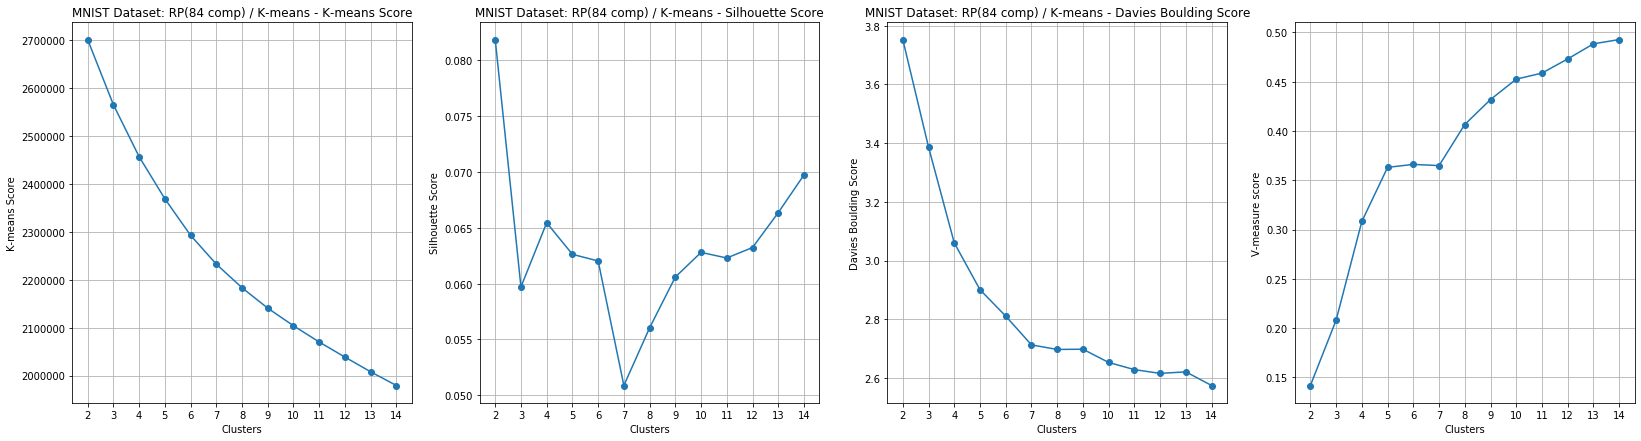

In [156]:
mtitle = "MNIST Dataset: RP(84 comp) / K-means"
build_kmeans_plots(mtitle, mk,ms,mv,md)

In [203]:
# 9 clusters Credit
Xm, ym, name = get_data(mnist_rp)
km_9 = KMeans(n_clusters=9,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_9_pred = km_9.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_9_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_9_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km_9.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km_9.labels_))

Adjusted Rand Score:      0.3114326415633972
Homogeneity Score:        0.44439293143903336
Silhouette Score:         0.06059688446625824
Calinski Harabasz Score:  2429.1047561519863


# Dictionary Learning

In [6]:
Xm, ym, _ = get_data(mnist)

dl = MiniBatchDictionaryLearning(n_components=23,
                                 alpha=1,
                                 batch_size=100,
                                 n_iter=25,
                                 random_state=random_state)
X_mnist_dl = dl.fit_transform(Xm)

In [70]:
data = {'X': X_mnist_dl, 'y': ym}
x_tsne = tSNE_transform(data, perplexity=40, n_iter=5000)

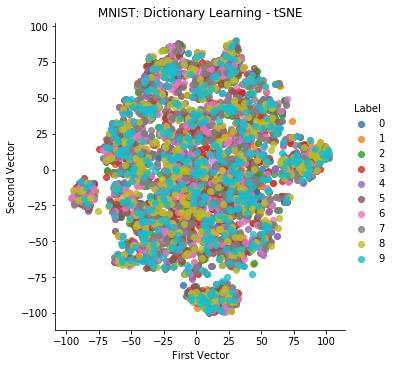

In [71]:
two_comp_scatter(x_tsne, ym, 'MNIST: Dictionary Learning - tSNE')

In [7]:
mnist_dl = {"X": X_mnist_dl, "y": y_mnist_train, "name": "MNIST Dictionary Learning"}
mk, ms, mv, md = build_kmeans_elbow_data(mnist_dl)

Clusters:  2
K-means score:        -8828068.772727018
Silhouette score:     0.12519237692219823
Davies Bouldin score: 2.400780359197867
V-measure score:      0.011751320532674869
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -8344927.164011688
Silhouette score:     0.08018715520327666
Davies Bouldin score: 2.757935984067368
V-measure score:      0.03602346445480349
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -7957900.539784722
Silhouette score:     0.07515476166379248
Davies Bouldin score: 2.624338022702412
V-measure score:      0.036110529918525015
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -7684025.687451167
Silhouette score:     0.07140951958736871
Davies Bouldin score: 2.576077741714666
V-measure score:      0.0

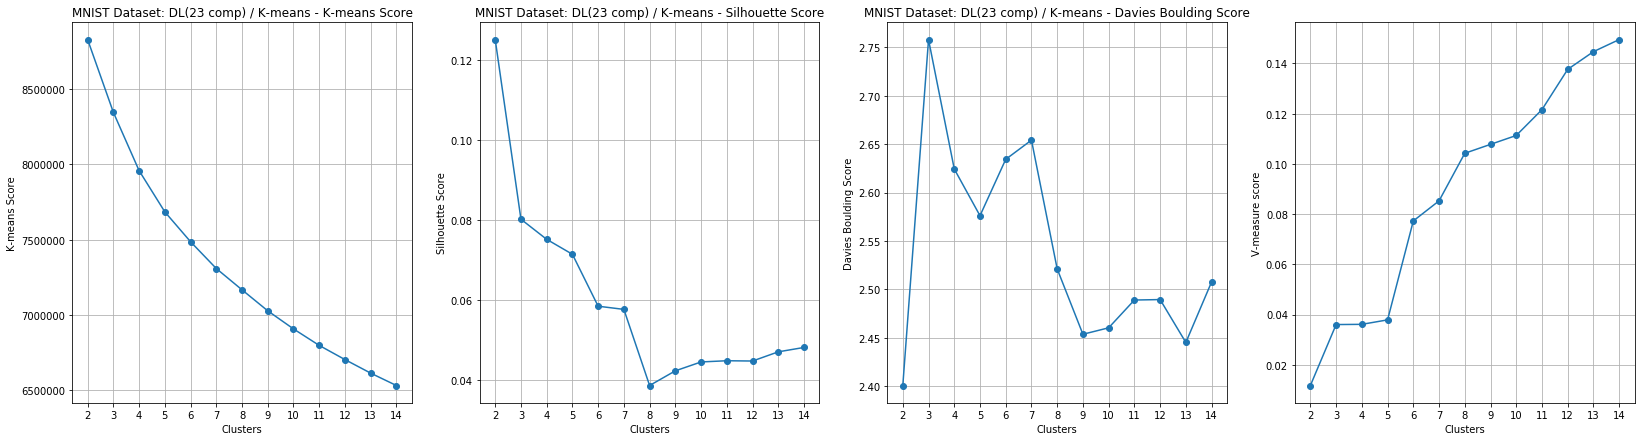

In [8]:
mtitle = "MNIST Dataset: DL(23 comp) / K-means"
build_kmeans_plots(mtitle, mk,ms,mv,md)

In [64]:
# 5 clusters Credit
Xm, ym, name = get_data(mnist_dl)
km = KMeans(n_clusters=5,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_pred = km.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km.labels_))

Adjusted Rand Score:      0.0219153547346642
Homogeneity Score:        0.0460730999732282
Silhouette Score:         0.07140951958736871
Calinski Harabasz Score:  4733.570222831995


In [65]:
# 7 clusters Credit
Xm, ym, name = get_data(mnist_dl)
km = KMeans(n_clusters=7,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_pred = km.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km.labels_))

Adjusted Rand Score:      0.062012182961309406
Homogeneity Score:        0.09323096237869055
Silhouette Score:         0.057605956696280054
Calinski Harabasz Score:  3798.2360641002815


In [68]:
# 8 clusters Credit
Xm, ym, name = get_data(mnist_dl)
km = KMeans(n_clusters=8,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_pred = km.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km.labels_))

Adjusted Rand Score:      0.054939510876937915
Homogeneity Score:        0.11068047146505235
Silhouette Score:         0.038536840590231596
Calinski Harabasz Score:  3477.908482863362


In [67]:
# 10 clusters Credit
Xm, ym, name = get_data(mnist_dl)
km = KMeans(n_clusters=10,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

km_pred = km.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_pred, ym.values.ravel()))
print("Silhouette Score:        ", silhouette_score(Xm, km.labels_, metric="euclidean"))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km.labels_))

Adjusted Rand Score:      0.06013190387775
Homogeneity Score:        0.1121177387150033
Silhouette Score:         0.044436292550863135
Calinski Harabasz Score:  3040.2570673968844
